# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
import time
from pyspark.sql.functions import regexp_extract
pd.options.display.max_rows = 999

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load data

In [3]:
# read first 5 rows
df = spark.read.json('mini_sparkify_event_data.json')
df.limit(5)

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Wind...,30
Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Win...",9
Adam Lambert,Logged In,Colin,M,51,Freeman,282.8273,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Wind...,30
Enigma,Logged In,Micah,M,80,Long,262.71302,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Knocking On Forbi...,200,1538352416000,"""Mozilla/5.0 (Win...",9
Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Fas...,200,1538352676000,Mozilla/5.0 (Wind...,30


In [4]:
# check the number of data
df.count()

286500

In [5]:
# check the number of columns
len(df.columns)

18

In [6]:
# check columns name
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [7]:
# Check data null
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [8]:
# check userID
df.select('userId').sort('userID').limit(10)

userId
""
""
""
""
""
""
""
""
""
""


user ID have an empty string, we need to remove it

In [9]:
# check top of duplicates userID
df.groupBy('userId').count().orderBy('count', ascending=False).limit(5)

userId,count
39,9632
,8346
92,7230
140,6880
300011,5732


we have many duplicates value in user Id, we need to remove duplicates user Id for EDA. Besides that, empty string user id have 8346 duplicates value

In [10]:
df.groupBy('gender').count()

gender,count
F,154578
null,8346
M,123576


At gender we have 8346 null values, it seem like empty string at user id make null gender 

In [11]:
df.groupBy('level').count()

level,count
free,58338
paid,228162


In [12]:
df.groupBy('page').count()

page,count
Cancel,52
Submit Downgrade,63
Thumbs Down,2546
Home,14457
Downgrade,2055
Roll Advert,3933
Logout,3226
Save Settings,310
Cancellation Conf...,52
About,924


In [13]:
df = df.filter(df['gender'] != '')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# Create new column Churn 
df = df.withColumn("churn", F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))

In [15]:
# Create columns for Total Downgrade and Total Churn
window_user = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("totalChurn", F.sum("churn").over(window_user))
df.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|totalChurn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|         0|
|Francesca Battist...|Logged In| Darianna|  

In [16]:
# sort data by ts to get last action to the first by each user
df_sort = df.orderBy('userID', desc('ts'))

In [17]:
df_unique_user = df_sort.dropDuplicates(['userID'])

### User Active vs User Cancel

In [18]:
# Create new df active or cancel
df_churn = df_unique_user.select(['userId', 'churn']).groupBy('churn').count()
df_churn

churn,count
1,51
0,174


In [19]:
# convert to pandas
df_churn = df_churn.toPandas()

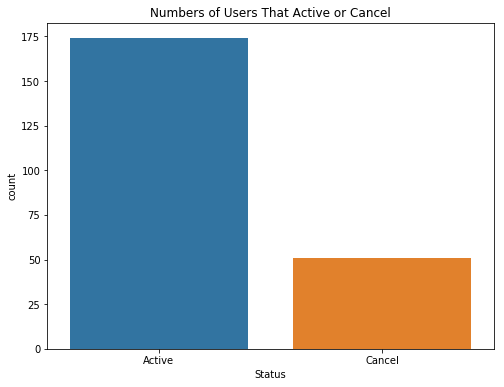

In [20]:
# draw chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')
ax.set_xticklabels(["Active", "Cancel"])
ax.set_xlabel("Status")
plt.title("Numbers of Users That Active or Cancel");
plt.savefig('./graph/Numbers of Users That Active or Cancel.png')

### Gender of users Active and Cancel

In [21]:
# create a df grouped by churn and gender
df_gender_churn = df_unique_user.select(['userId', 'churn', 'gender']).groupBy('gender', 'churn').count()
df_gender_churn

gender,churn,count
M,1,31
F,0,84
F,1,20
M,0,90


In [22]:
# convert to pandas
df_gender_churn = df_gender_churn.toPandas()

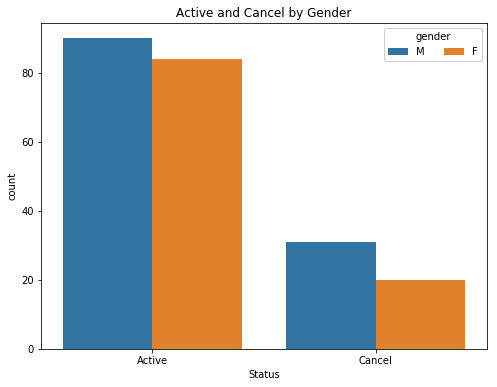

In [23]:
# draw chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender_churn, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
ax.set_xlabel("Status")
ax.set_xticklabels(["Active", "Cancel"])
plt.title("Active and Cancel by Gender");
plt.savefig('./graph/Active and Cancel by Gender.png')

### Level of Users Active and Cancel

In [24]:

# create the dataframe level
df_level_churn = df_unique_user.select(['userId', 'churn', 'level']).groupBy('level','churn').count()
df_level_churn

level,churn,count
paid,0,114
free,0,60
paid,1,31
free,1,20


In [25]:
# convert to pandas
df_level_churn = df_level_churn.toPandas()

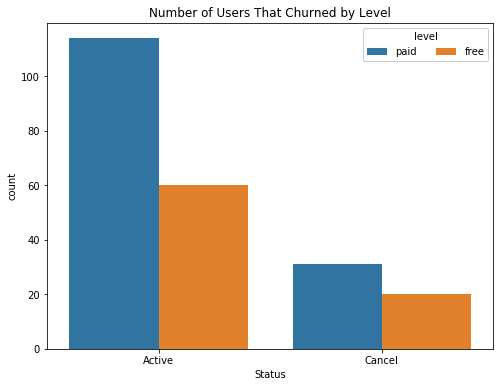

In [26]:
# draw chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level_churn, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
ax.set_xticklabels(["Active", "Cancel"])
ax.set_xlabel("Status")
plt.title("Number of Users That Churned by Level");
plt.savefig('./graph/Number of Users That Churned by Level.png')

In [27]:
df_gender_level = df_unique_user.select(['userID', 'gender', 'level']).groupBy('gender','level').count()

In [28]:
# convert to pandas 
df_gender_level = df_gender_level.toPandas()

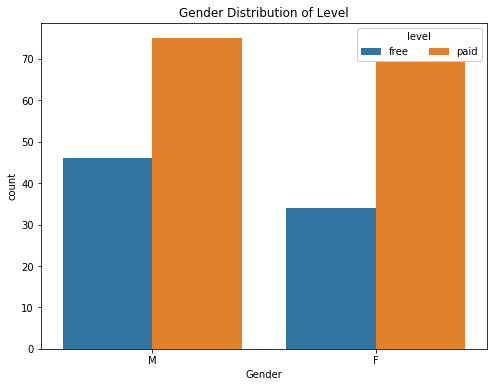

In [29]:
# draw chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender_level, x = 'gender', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
ax.set_xlabel("Gender")
plt.title("Gender Distribution of Level");
plt.savefig('./graph/Gender Distribution of Level.png')

In [30]:
# Check the number of male and female in data
df_gender  = df.select(['userId', 'gender']).dropDuplicates()
df_gender.limit(5)

userId,gender
44,F
46,F
41,F
72,F
300023,F


In [31]:
# convert to pandas 
df_gender = df_gender.toPandas()

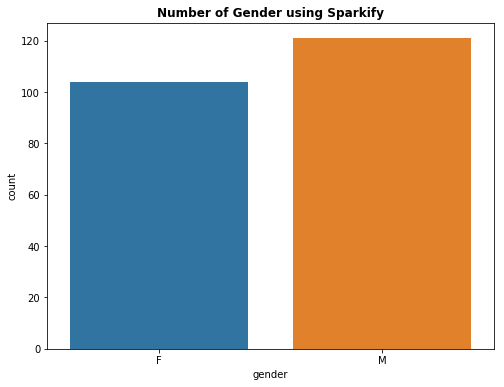

In [32]:
# Create chart to show number of male and female
plt.figure(figsize = [8,6])
# df_gender_count = df_gender.select('gender').toPandas()
ax = sns.countplot(data = df_gender,  x = 'gender')
plt.title("Number of Gender using Sparkify", fontweight='bold');
plt.savefig('./graph/Number of Gender using Sparkify.png')

Male use Sparkify more than Female

In [33]:
gender_level = df_unique_user.select('gender', 'level', 'userId')

In [34]:
df_gender_level = gender_level.groupby(['gender', 'level']).count().sort('gender').toPandas()
df_gender_level['ratio'] = df_gender_level['count']/df_gender_level.groupby('gender')['count'].transform('sum') * 100


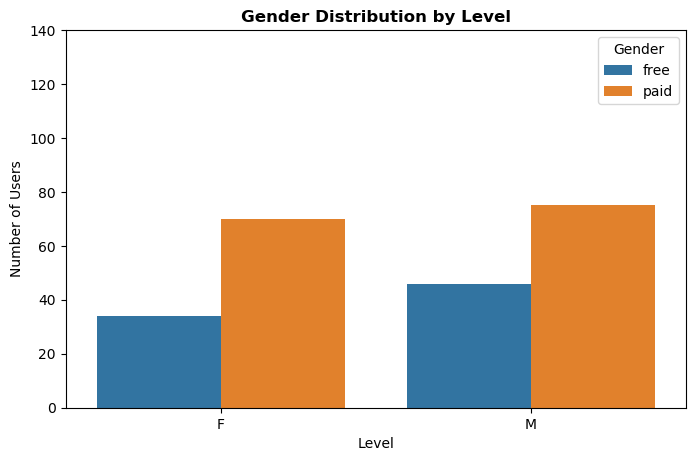

In [35]:
# reference to add name of x label:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100);
sns.barplot(data = df_gender_level, x="gender", y = "count", hue="level");
plt.ylim([0,140]);
plt.title("Gender Distribution by Level", fontweight='bold');
plt.xlabel("Level");
plt.ylabel("Number of Users");
plt.legend(title='Gender');
plt.savefig('./graph/Gender Distribution by Level.png')

Ratio of Female Pay account more than Male

### Top 10 song

In [36]:
song = df.toPandas()

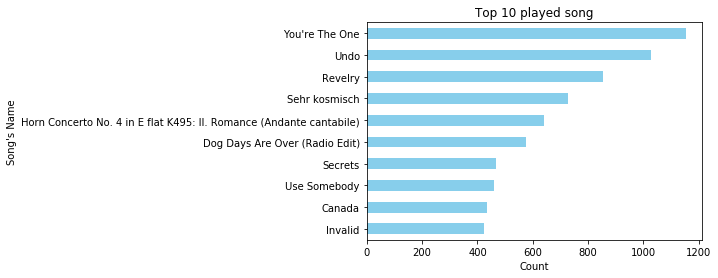

In [37]:
top_10_song = song['song'].value_counts()[:10].sort_values()
ax = top_10_song.plot(kind='barh',  color='skyblue')
plt.title('Top 10 played song')
plt.ylabel("Song's Name" )
plt.xlabel('Count');
plt.savefig('./graph/Top 10 played song.png')

### Top 10 artist 

In [38]:
artist = df.toPandas()

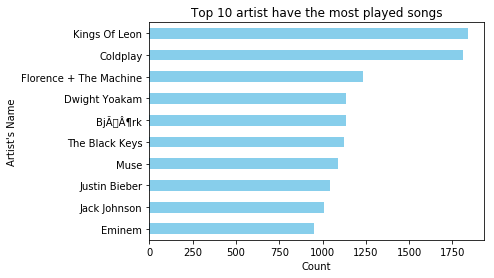

In [39]:
top_10_artist = artist['artist'].value_counts()[:10].sort_values()
ax = top_10_artist.plot(kind='barh',  color='skyblue')
# Add value labels to each bar
# for i, v in enumerate(dow):
#     ax.text(60000 + (v-60000)/2, i , str(v), color='black', fontweight='bold', va = 'center')
plt.title('Top 10 artist have the most played songs')
plt.ylabel("Artist's Name" )
plt.xlabel('Count');
plt.savefig('./graph/Top 10 artist have the most played songs.png')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [40]:
# Create user dataframe
df_feature = df.select('userId', 'level', 'gender', 'churn', 'ts', 'length', 'artist', 'song', 'page')

df_user = df_feature.groupBy('userId').agg(
    F.avg('length').alias('avg_song_length'),
    F.countDistinct('artist').alias('total_artist'),
    F.countDistinct('song').alias('total_song'),
    F.count('page').alias('total_session'),
    F.count(F.when(F.col('page') == 'Thumbs Up', True)).alias('total_thumb_up'),
    F.count(F.when(F.col('page') == 'Thumbs Down', True)).alias('total_thumb_down'),
    F.count(F.when(F.col('page') == 'Add Friend', True)).alias('total_add_friend'),
    F.count(F.when(F.col('page') == 'Add to Playlist', True)).alias('total_add_playlist'),
    F.countDistinct(F.when(F.col('gender') == 'F', True)).alias('female'),
    F.countDistinct(F.when(F.col('gender') == 'M', True)).alias('male')
)
df_user.limit(5)

userId,avg_song_length,total_artist,total_song,total_session,total_thumb_up,total_thumb_down,total_add_friend,total_add_playlist,female,male
100010,243.421444909091,252,269,381,17,5,4,7,1,0
200002,242.91699209302305,339,378,474,21,6,4,8,0,1
125,261.13913750000006,8,8,11,0,0,0,0,0,1
51,247.88055082899118,1385,1854,2464,100,21,28,52,0,1
124,248.17653659965674,2232,3339,4825,171,41,74,118,1,0


In [41]:
label = df.select('userId', F.col('churn')).dropDuplicates()
label.limit(5)

userId,churn
73,0
19,0
100005,1
200007,0
300007,1


In [42]:
data = df_user.join(label, "userId").drop("userId")
data = data.dropna()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [43]:
feature_col = data.columns[:-1]
feature_col

['avg_song_length',
 'total_artist',
 'total_song',
 'total_session',
 'total_thumb_up',
 'total_thumb_down',
 'total_add_friend',
 'total_add_playlist',
 'female',
 'male']

In [44]:
# split the data to 75% training and 25% testing, set random state to 42.
train, test = data.randomSplit([0.75, 0.25], seed=42)

In [45]:
def build_model(classifier, param):
    """
        Build the classfication model with Cross Validation
    
    Input:
        classifier: Model name
        param: parameter tuning for the model
    
    Return:
        Classfication model
    """
    # create a vector for the features
    assembler = VectorAssembler(inputCols=feature_col, outputCol="features_vec")
    # normalize the Vectors
    scaler = Normalizer(inputCol="features_vec", outputCol="features")
    # build Pipeline
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [46]:
def evaluate_model(pred):
    """ 
    Input: 
        Pred: prediction values to make an evaluation model
    Return:
    
        Model evaluation with F1 score metric 
    
    """
    # using multiclassclassificationevaluator to get the F1 scores
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
    f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    print('F1 score: {}'.format(f1_score))
    return f1_score

In [47]:
# Create 2 list to store model and f1_score
lst_model = []
lst_score = []

In this projet we will using models below:
* Logistic Regression
* Linear Support Vector Machine
* Random Forest Classifier
* Gradient-Boosted Tree Classifier
* Naive Bayes

### Reason choose these models

**Logistic regression**: This is a binary classification problem and that logistic regression produces a model with acceptable explainability, logistic regression is a trustworthy machine learning approach to try. Additionally simple to use, analyze, and train, logistic regression is an effective tool. It also has a lower propensity to overfit.

**Random Forest**: For classification, Random Forest is an effective supervised learning system. RF is an ensemble method that uses several decision trees to generate predictions and bases the final decision on a majority vote. By doing so, overfitting may be prevented. Additionally, RF performs well on imbalanced datasets, such as the ones we have here, and is robust.

**Gradient Boosted Tree Classifier (GBT)**: Unlike RF, which develops trees separately, this builds trees one at a time, with each new tree helping to remedy mistakes caused by the prior tree. With GBT, there is a chance of overfitting, therefore this must be taken into account. Nonetheless, GBT functions well with the unbalanced data that we have available.

**Linear SVC**: It is memory-efficient and functions effectively with distinct class boundaries.

**Naive Bayes**: This classifier algorithm is also fast and simple to build.

**Logistic regression**

In [48]:
lr = LogisticRegression(featuresCol="features", labelCol="churn")
lr_param = ParamGridBuilder().build()
lr_model = build_model(lr, lr_param)
lst_model.append('Logistic regression')

In [49]:
start_time = time.time()
lr_fit_model = lr_model.fit(train)
print("Train time:", time.time() - start_time, 'seconds')

Train time: 910.7843353748322 seconds


In [50]:
lr_pred = lr_fit_model.transform(test)

In [51]:
lst_score.append(evaluate_model(lr_pred))

F1 score: 0.7156482861400895


**Random Forest**

In [52]:
rfc = RandomForestClassifier(featuresCol="features", labelCol="churn")
rfc_param = ParamGridBuilder().build()
rfc_model = build_model(rfc, rfc_param)
lst_model.append('Random Forest')

In [53]:
start_time = time.time()
rfc_fit_model = rfc_model.fit(train)
print("Train time:", time.time() - start_time, 'seconds')

Train time: 484.9443645477295 seconds


In [54]:
rfc_pred = rfc_fit_model.transform(test)

In [55]:
lst_score.append(evaluate_model(rfc_pred))

F1 score: 0.6906695265818906


**Gradient Boosted Tree Classifier (GBT)**

In [56]:
gb = GBTClassifier(featuresCol="features", labelCol="churn")
gb_param = ParamGridBuilder().build()
gb_model = build_model(gb, gb_param)
lst_model.append('GBT')

In [57]:
start_time = time.time()
gb_fit_model = gb_model.fit(train)
print("Train time:", time.time() - start_time, 'seconds')

Train time: 1487.306233882904 seconds


In [58]:
gb_pred = gb_fit_model.transform(test)

In [59]:
lst_score.append(evaluate_model(gb_pred))

F1 score: 0.6642496847414879


**Linear SVC**

In [60]:
svc = LinearSVC(featuresCol="features", labelCol="churn")
svc_param = ParamGridBuilder().build()
svc_model = build_model(svc, svc_param)
lst_model.append('Linear SVC')

In [61]:
start_time = time.time()
svc_fit_model = svc_model.fit(train)
print("Train time:", time.time() - start_time, 'seconds')

Train time: 4393.905734300613 seconds


In [62]:
svc_pred = svc_fit_model.transform(test)

In [63]:
lst_score.append(evaluate_model(svc_pred))

F1 score: 0.7156482861400895


**Naive Bayes**

In [64]:
nb = NaiveBayes(featuresCol="features", labelCol="churn")
nb_param = ParamGridBuilder().build()
nb_model = build_model(nb, nb_param)
lst_model.append('Naive Bayes')

In [65]:
start_time = time.time()
nb_fit_model = nb_model.fit(train)
print("Train time:", time.time() - start_time, 'seconds')

Train time: 348.7986526489258 seconds


In [66]:
nb_pred = nb_fit_model.transform(test)

In [67]:
lst_score.append(evaluate_model(nb_pred))

F1 score: 0.7156482861400895


As we can see, Linear SVC and Naive Bayes have the same score but Naive Bayes have shorter times to train data. So we try to improve 

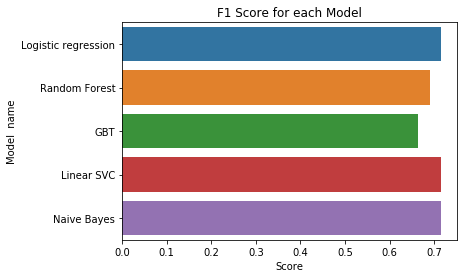

In [69]:
sns.barplot(y = lst_model, x = lst_score)
plt.xlabel('Score')
plt.ylabel('Model  name')
plt.title('F1 Score for each Model')
plt.show();
plt.savefig('./graph/F1 Score for each Model.png')

Naive Bayes have the least time to train but give the same score like Linear SVC and Logistic Regression.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.